<a href="https://colab.research.google.com/github/mmassonn/heart_attack_prediction/blob/main/heart_attack_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet : Heart attack prediction


##I. Définir l'objectif

Objectif : Prédiction du risque d’infartus à partir des données cliniques

metrique : c-index

##II. Importer les bibliothèques/framework

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##III. EDA(Exploration et analyse des données)

In [3]:
#load data
df = pd.read_csv('drive/MyDrive/Projet_2022/heart_attack_prediction/dataset.csv')

###1.shape analysis

In [4]:
#explore first fives rows ==> df values
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


###Les caractériqtiques sont les suivantes :

Age: age du patient [années]

Sex: sex du patient [M: Homme, F: Femme]

ChestPainType: type de douleur thoracique [TA: Angine typique, ATA: Angine atypique, NAP: Douleur non angineuse, ASY: Asymptomatique]

RestingBP: tension artérielle au repos [mm Hg]

Cholesterol: cholestérol sérique [mm/dl]

FastingBS: glycémie à jeun [1: si FastingBS > 120 mg/dl, 0: autre]

RestingECG: résultats de l'électrocardiogramme au repos [Normal: Normal, ST: ayant une anomalie de l'onde ST-T (T inversions d'ondes et/ou ST élevation ou dépression > 0.05 mV), LVH: montrant une hypertrophie ventriculaire gauche probable ou certaine par le critére 'Estes']

MaxHR: fréquence cardiaque maximale atteinte [Valeur numérique entre 60 et 202]

ExerciseAngina: angine induite par l'effort [Y: OUI, N: NON]

Oldpeak: oldpeak = ST [Valeur numérique mesurée en dépression]

ST_Slope: la pente du segment ST d'effort maximal [Up: ascendant, Flat: plat, Down: descendant]

HeartDisease: Cardiopathie [1: OUI, 0: NON]

target identification : target

In [5]:
#shape
df.shape 

(918, 12)

Nombre de lignes = 918 patients

Nombre de colonnes = 11 caractéristiques + 1 cible

Cible = Cardiopathie



In [6]:
#variable types
df.dtypes.value_counts()

int64      6
object     5
float64    1
dtype: int64

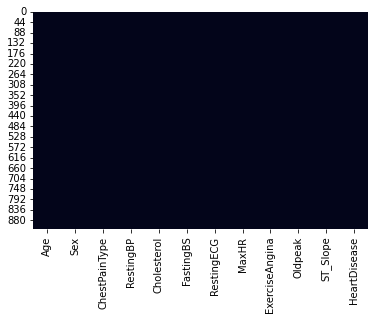

In [7]:
#Nan values   
sns.heatmap(df.isna(), cbar=False)

Il n'y a pas de valeur manquante.

###2.data analysis

### RELATION : VARIABLE DISTRIBUTIONS

## Variable Cible

In [8]:
#target vizualisation
df['HeartDisease'].value_counts(normalize = True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

###Concernant la cible

Il y a 55% de patients atteint de cardiopathie et 45% de patients non atteint de cardiopathie. La base de donnée est équilibrée.

## Variable quantitative

In [9]:
#continuous variables
df_continuous = df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

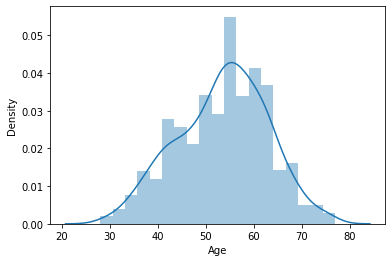

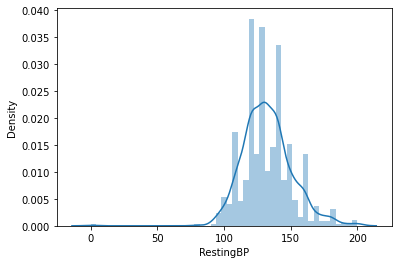

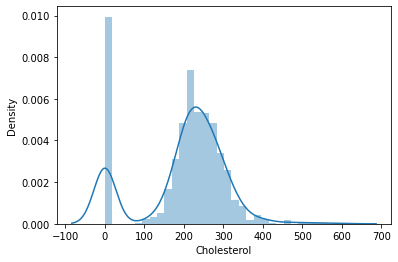

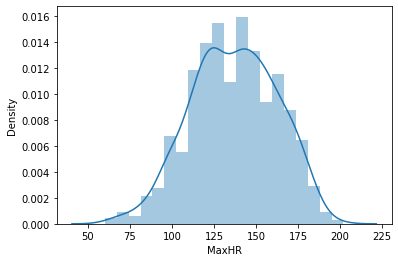

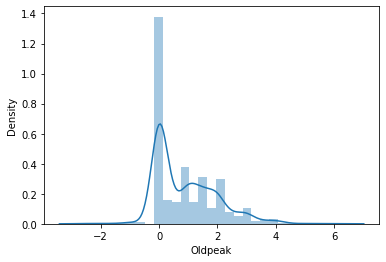

In [10]:
#continue variables histograms
for col in df_continuous:
    plt.figure()
    sns.distplot(df_continuous[col])

In [11]:
#target vizualisation
(df['Cholesterol']==0).value_counts(normalize = True)

False    0.812636
True     0.187364
Name: Cholesterol, dtype: float64

###Concernant les variables quantitative

Age du patient : semble suivre une loi de distribution normale.

Tension artérielle au repos : semble suivre une loi de distribution normale.

Cholestérol sérique : semble suivre une loi de distribution normale pour la plupart des patients. Cependant 19 % des patients affichent 0 mm/dl. Nous supposons que ces valeurs sont aberantes et devront être écartées.

Fréquence cardiaque maximale atteinte : semble suivre une loi de distribution normale.

Oldpeak : ne semble pas suivre une loi de distribution normale.

## Variable qualitative

In [12]:
#qualitative variables
df_qualitative = df[['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]

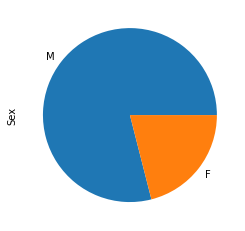

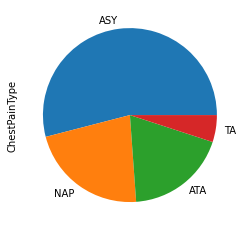

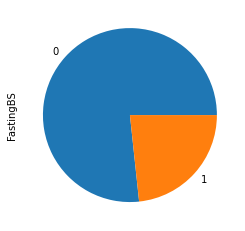

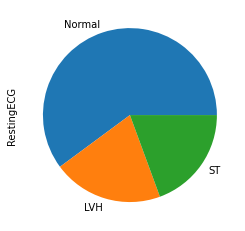

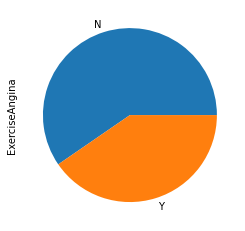

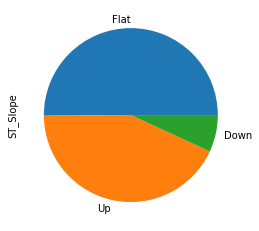

In [13]:
#qualitative variables pie:
for col in df_qualitative:
    plt.figure()
    df_qualitative[col].value_counts().plot.pie()

###Concernant les variables qualitatives

Sex du patient : 78 % d'homme et 21% de Femmes.

Type de douleur thoracique : 5% d'angine typique, 19% d'angine atypique, 22% de douleur non angineuse et 54% d'asymptomatique.

Glycémie à jeun : 23% >120 mg/dl et 77% <=120 mg/dl.

Résultats de l'électrocardiogramme au repos : 60% de normal, 19% de ST et 21% montrant une LVH.

Angine induite par l'effort : 60% des patients et 40% des patients.


La pente du segment ST d'effort maximal : 43% de pente ascendante, 50% de plat et 7% de pente descendante.

###RELATION : CIBLE-VARIABLE

In [14]:
#continuous variables + target
df_continuous = df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']]

In [15]:
#created positive and negative under set
positive_df = df_continuous[df_continuous['HeartDisease'] == 1]   
negative_df = df_continuous[df_continuous['HeartDisease'] == 0]   

In [16]:
#created positive and negative under set
features_df = df_continuous.drop('HeartDisease', axis=1) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

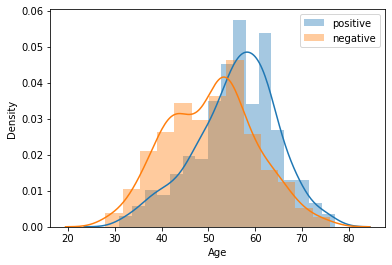

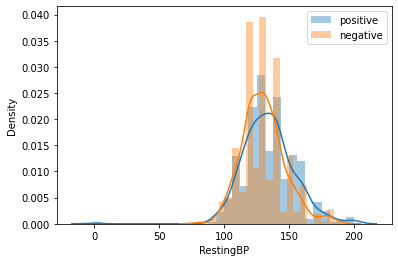

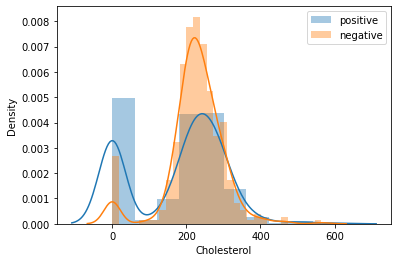

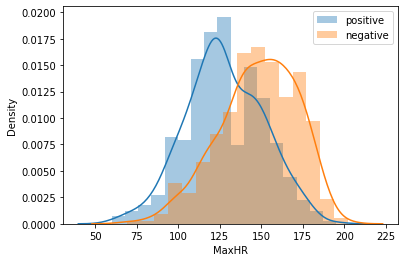

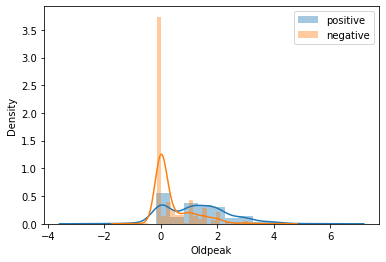

In [17]:
#target/feature_df :
for col in features_df:
    plt.figure()
    sns.distplot(positive_df[col], label='positive')
    sns.distplot(negative_df[col], label = 'negative')
    plt.legend()  

###hypothèses : 

1-les individus plus âgés sont plus succeptible de développer une cardiopathie.

2-les individus atteignant une fréquence cardiaque maximale plus basse sont plus succeptible de développer une cardiopathie.

3-Les individus possédant yne valeur en dépression ST nulle est plus succeptible de développer une cardiopathie.

In [18]:
#qualitative variables + target
df_qualitative = df[['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']]

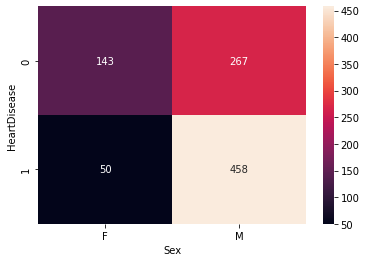

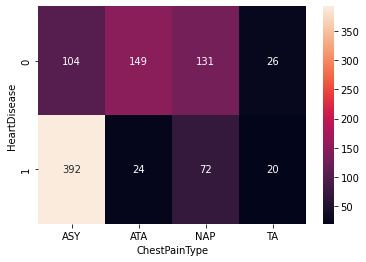

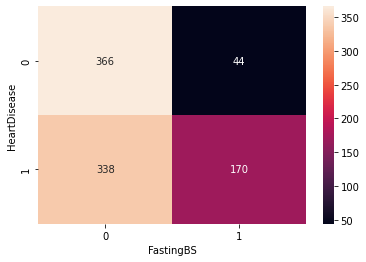

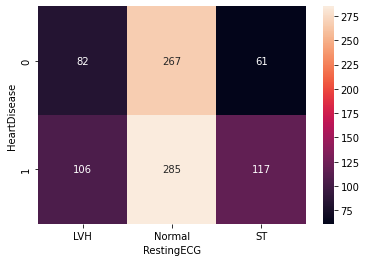

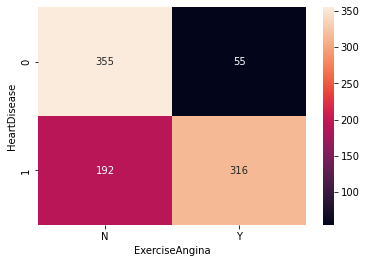

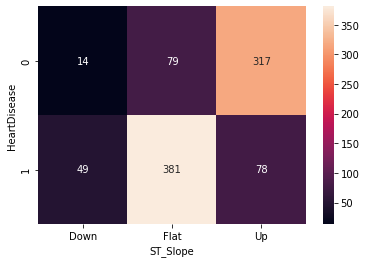

In [19]:
#Target/viral
for col in df_qualitative.drop(['HeartDisease'], axis=1):
    plt.figure()
    sns.heatmap(pd.crosstab(df_qualitative['HeartDisease'],df_qualitative[col]), annot=True,fmt='d')

###hypothèses : 

4-Sex du patient : les hommes sont plus succeptible de développer une cardiopathie que les femmes.

5-Type de douleur thoracique : les individus asymptomatique pour une douleur thoracique sont plus succeptible de développer une cardiopathie. 

6-En revanche les patients atteint de douleur toracique de type angine atypique ou de douleur non angineuse sont moins succeptible de développer une cardiopathie.

7-Glycémie à jeun : les individus dont la glycémie est supérieur à 120 mg/dl sont plus succeptible de développer une cardiopathie.

8-Résultats de l'électrocardiogramme au repos : les individus ayant une anomalie de l'onde ST-T sont plus succeptible de développer une cardiopathie.

9-Angine induite par l'effort : les individus ayant une angine induite par l'effort sont plus succeptible de développer une cardiopathie.


10-La pente du segment ST d'effort maximal : les individus présentant une  pente du segment ST d'effort maximal plate sont plus succeptible de développer une cardiopathie.


###RELATION : VARIABLE-VARIABLE

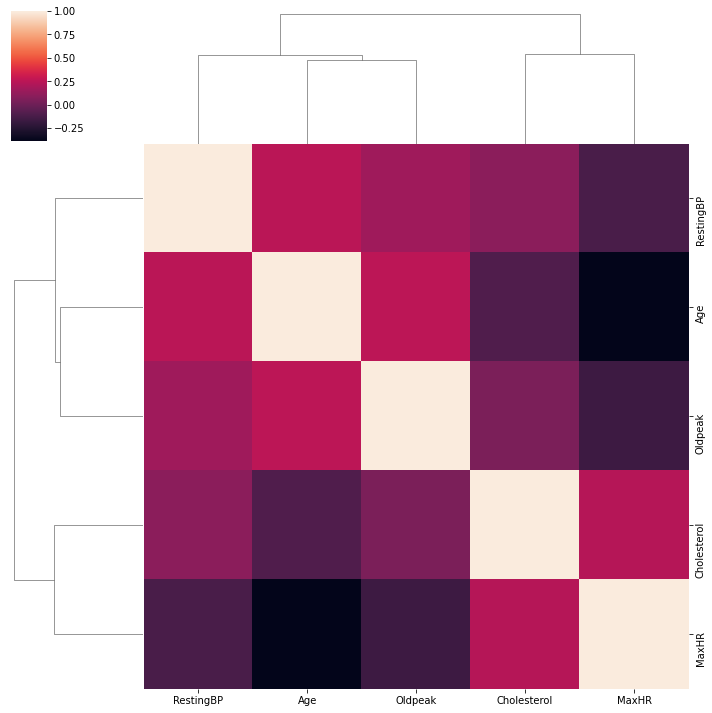

In [25]:
sns.clustermap(df_continuous.drop(['HeartDisease'], axis=1).corr())

Observation : Pas d'importante correlation entre les variables continues.

In [26]:
from statsmodels.graphics.mosaicplot import mosaic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Sex vs qualitative variables

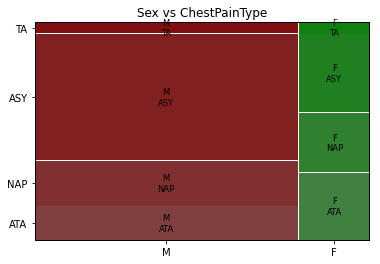

In [33]:
mosaic(df_qualitative, ['Sex', 'ChestPainType'], title='Sex vs ChestPainType')
plt.show()

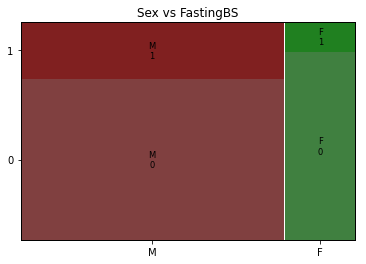

In [34]:
mosaic(df_qualitative, ['Sex', 'FastingBS'], title='Sex vs FastingBS')
plt.show()

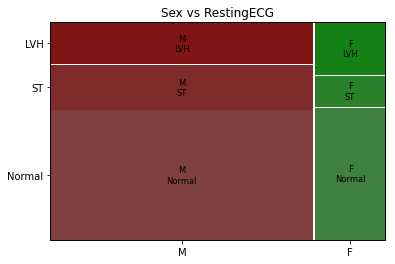

In [35]:
mosaic(df_qualitative, ['Sex', 'RestingECG'], title='Sex vs RestingECG')
plt.show()

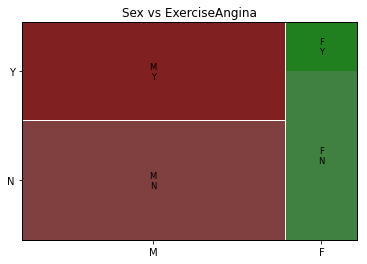

In [36]:
mosaic(df_qualitative, ['Sex', 'ExerciseAngina'], title='Sex vs ExerciseAngina')
plt.show()

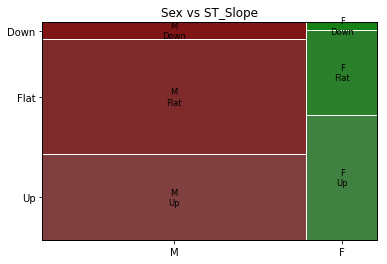

In [37]:
mosaic(df_qualitative, ['Sex', 'ST_Slope'], title='Sex vs ST_Slope')
plt.show()

### ChestPaintype vs qualitative variables

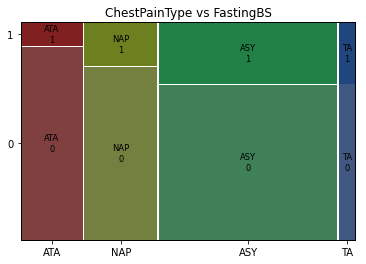

In [39]:
mosaic(df_qualitative, ['ChestPainType', 'FastingBS'], title='ChestPainType vs FastingBS')
plt.show()

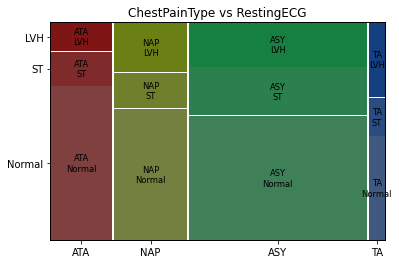

In [40]:
mosaic(df_qualitative, ['ChestPainType', 'RestingECG'], title='ChestPainType vs RestingECG')
plt.show()

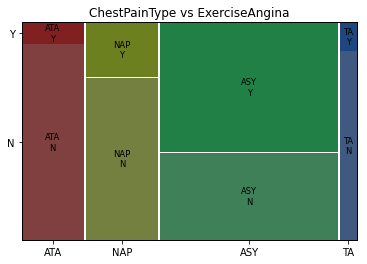

In [41]:
mosaic(df_qualitative, ['ChestPainType', 'ExerciseAngina'], title='ChestPainType vs ExerciseAngina')
plt.show()

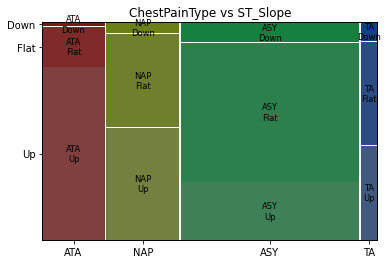

In [42]:
mosaic(df_qualitative, ['ChestPainType', 'ST_Slope'], title='ChestPainType vs ST_Slope')
plt.show()

### FastingBS vs qualitative variables

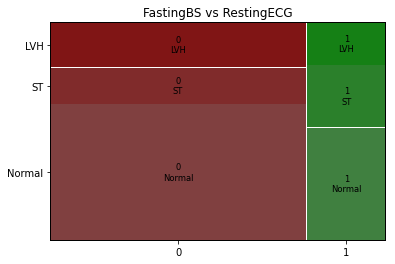

In [43]:
mosaic(df_qualitative, ['FastingBS', 'RestingECG'], title='FastingBS vs RestingECG')
plt.show()

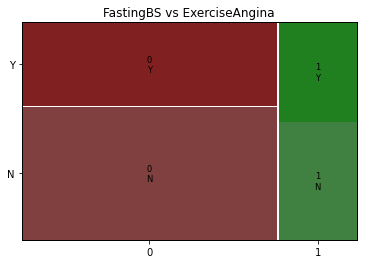

In [44]:
mosaic(df_qualitative, ['FastingBS', 'ExerciseAngina'], title='FastingBS vs ExerciseAngina')
plt.show()

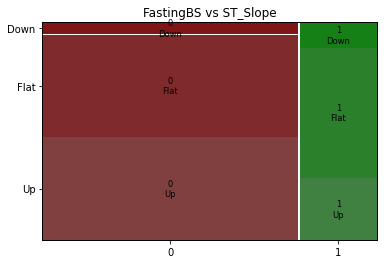

In [45]:
mosaic(df_qualitative, ['FastingBS', 'ST_Slope'], title='FastingBS vs ST_Slope')
plt.show()

### RestingECG vs qualitative variables

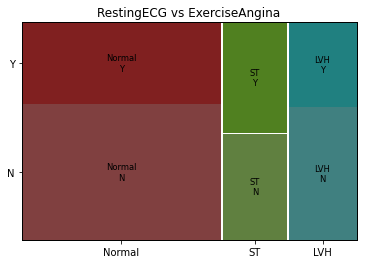

In [46]:
mosaic(df_qualitative, ['RestingECG', 'ExerciseAngina'], title='RestingECG vs ExerciseAngina')
plt.show()

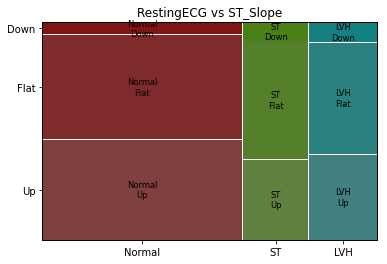

In [47]:
mosaic(df_qualitative, ['RestingECG', 'ST_Slope'], title='RestingECG vs ST_Slope')
plt.show()

### ExerciseAngina vs qualitative variables

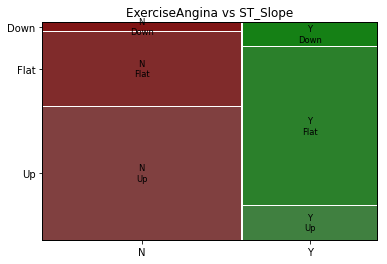

In [48]:
mosaic(df_qualitative, ['ExerciseAngina', 'ST_Slope'], title='ExerciseAngina vs ST_Slope')
plt.show()

###Observation : 

Les hommes sont plus asymptomatiques que les femmes.

Les hommes sont plus succeptible de déclancher une angine lors de l'effort.

Les patients asymptomatiques sont plus succeptible de développer une angine durant l'exercice. 

Les patients asymptomatiques sont plus succeptible de présenter une pente du segment ST d'effort maximal plate.

Les patients développant une angine durant l'exercice sont plus succeptible de présenter une pente du segment ST d'effort maximal plate.

NULL HYPOTHESIS (H0):

Les individus ayant une crise cardiaque ont  une fréquence cardiaque maximale atteinte (thalach) significativement différents
H0 = la fréquence cardiaque maximale atteinte est égal chez les individus positifs et négatifs.


In [ ]:
#import packages 
from scipy.stats import ttest_ind

In [ ]:
#normalement autant de positif que de négatif mais ce n'est pas le cas
positive_df.shape
negative_df.shape

In [ ]:
balanced_neg = positive_df.sample(negative_df.shape[0])

In [ ]:
#defined t-test
def t_test(col):
    alpha =0.02
    stat, p = ttest_ind(balanced_neg[col], positive_df[col])
    if p< alpha:
        return 'HO rejetée'
    else: 
        return 0

for col in features_df :
    print (f'{col :-<50} {t_test(col)}')

#IV. Pre-processing

In [ ]:
#import packages     
from sklearn.model_selection import train_test_split

In [ ]:
#split Train and Test set  
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
trainset['target'].value_counts()
testset['target'].value_counts()

In [ ]:
#defined encodage, feature_engineering and imputation tools

def make_standard_normal(df):
    
    # Remove skew by applying the log function to the train set, and to the test set
    df= np.log(df)
    
    #calculate the mean and standard deviation of the training set
    mean = df.mean(axis = 0)
    stdev = df.std(axis = 0)
    
    # standardize the training set
    df = (df-mean)/stdev
 
    return df


def imputation(df):   
    df = df.dropna(axis=0)
    return df

#defined pre-processing    
def preprocessing(df):
    col=['age','trestbps', 'chol', 'thalach']
    df[col] = df[col].apply(make_standard_normal)
    df = imputation(df)
    
    X = df.drop('target', axis =1)
    y = df['target']
    
    print(y.value_counts())
    
    return X,y

In [ ]:
#applied pre-processing
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

#V. Modelling

In [ ]:
#import modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  StandardScaler

In [ ]:
#pipelined pre-processor and model
RandomForest = RandomForestClassifier (random_state = 0)
AdaBoost = AdaBoostClassifier (random_state = 0)
SVM = make_pipeline(StandardScaler(),SVC (probability=True))
KNN = make_pipeline(StandardScaler(),KNeighborsClassifier ())

#VI. Evaluation process

In [ ]:
#import modules
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve

##defined evaluation


In [ ]:
#Evaluate the model using the C-index
def cindex(y_true, scores):
    n = len(y_true)
    assert len(scores) == n
    concordant = 0
    permissible = 0
    ties = 0 
   # use two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n): #choose the range of j so that j>i
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1
                # For permissible pairs, check if they are concordant or are ties
                # check for ties in the score
                if scores[i] == scores[j]:
                    # count the tie
                    ties += 1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue
                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier
                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier
    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + 0.5 * ties) / permissible
    return c_index

##defined evaluation model

In [ ]:
#defined evaluation model
def evaluation(model):
    model.fit(X_train, y_train) 
    y_train_preds = model.predict_proba(X_train)[:, 1]
    print(cindex(y_train.values, y_train_preds))
    
    y_test_preds = model.predict_proba(X_test)[:, 1]
    print(cindex(y_test.values, y_test_preds))
       
    N,train_score,val_score = learning_curve(model, X_train, y_train, cv=4, scoring ='f1') 
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='val score')
    plt.legend()  

In [ ]:
#evaluated many models
dict_of_models = {'RandomForest' : RandomForest,'AdaBoost' : AdaBoost,'SVM': SVM,'KNN': KNN}
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)